In [1]:
import numpy as np
from Utils.discrete_family import discrete_family
from Utils.barrier_affine import solve_barrier_tree, solve_barrier_tree_nonneg, solve_barrier_tree_box_PGD
from CART import RegressionTree
from scipy.interpolate import interp1d
from scipy.stats import multivariate_normal as mvn
from Utils.plotting import  *
from Utils.simulation_helpers import *

# Data Generation

In [2]:
n = 50
p = 5
X = np.random.normal(size=(n, p))
a = 1
b = 1

mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
sd = 1.
noise_sd = 0.5
y = mu + np.random.normal(size=(n,), scale=sd)

In [3]:
# Create and train the regression tree
reg_tree = RegressionTree(min_samples_split=10, max_depth=3, min_proportion=0.2)
reg_tree.fit(X, y, sd = noise_sd)

In [4]:
n_test = 50
X_test = np.random.normal(size=(n_test, p))
mu_test = b * ((X_test[:, 0] <= 0) * (1 + a * (X_test[:, 1] > 0) 
                                      + (X_test[:, 2] * X_test[:, 1] <= 0)))
y_test = mu_test + np.random.normal(size=(n_test,), scale=sd)

In [5]:
pred_test = reg_tree.predict(X_test)

In [6]:
RMSE_unpruned = np.mean((y_test - pred_test)**2)

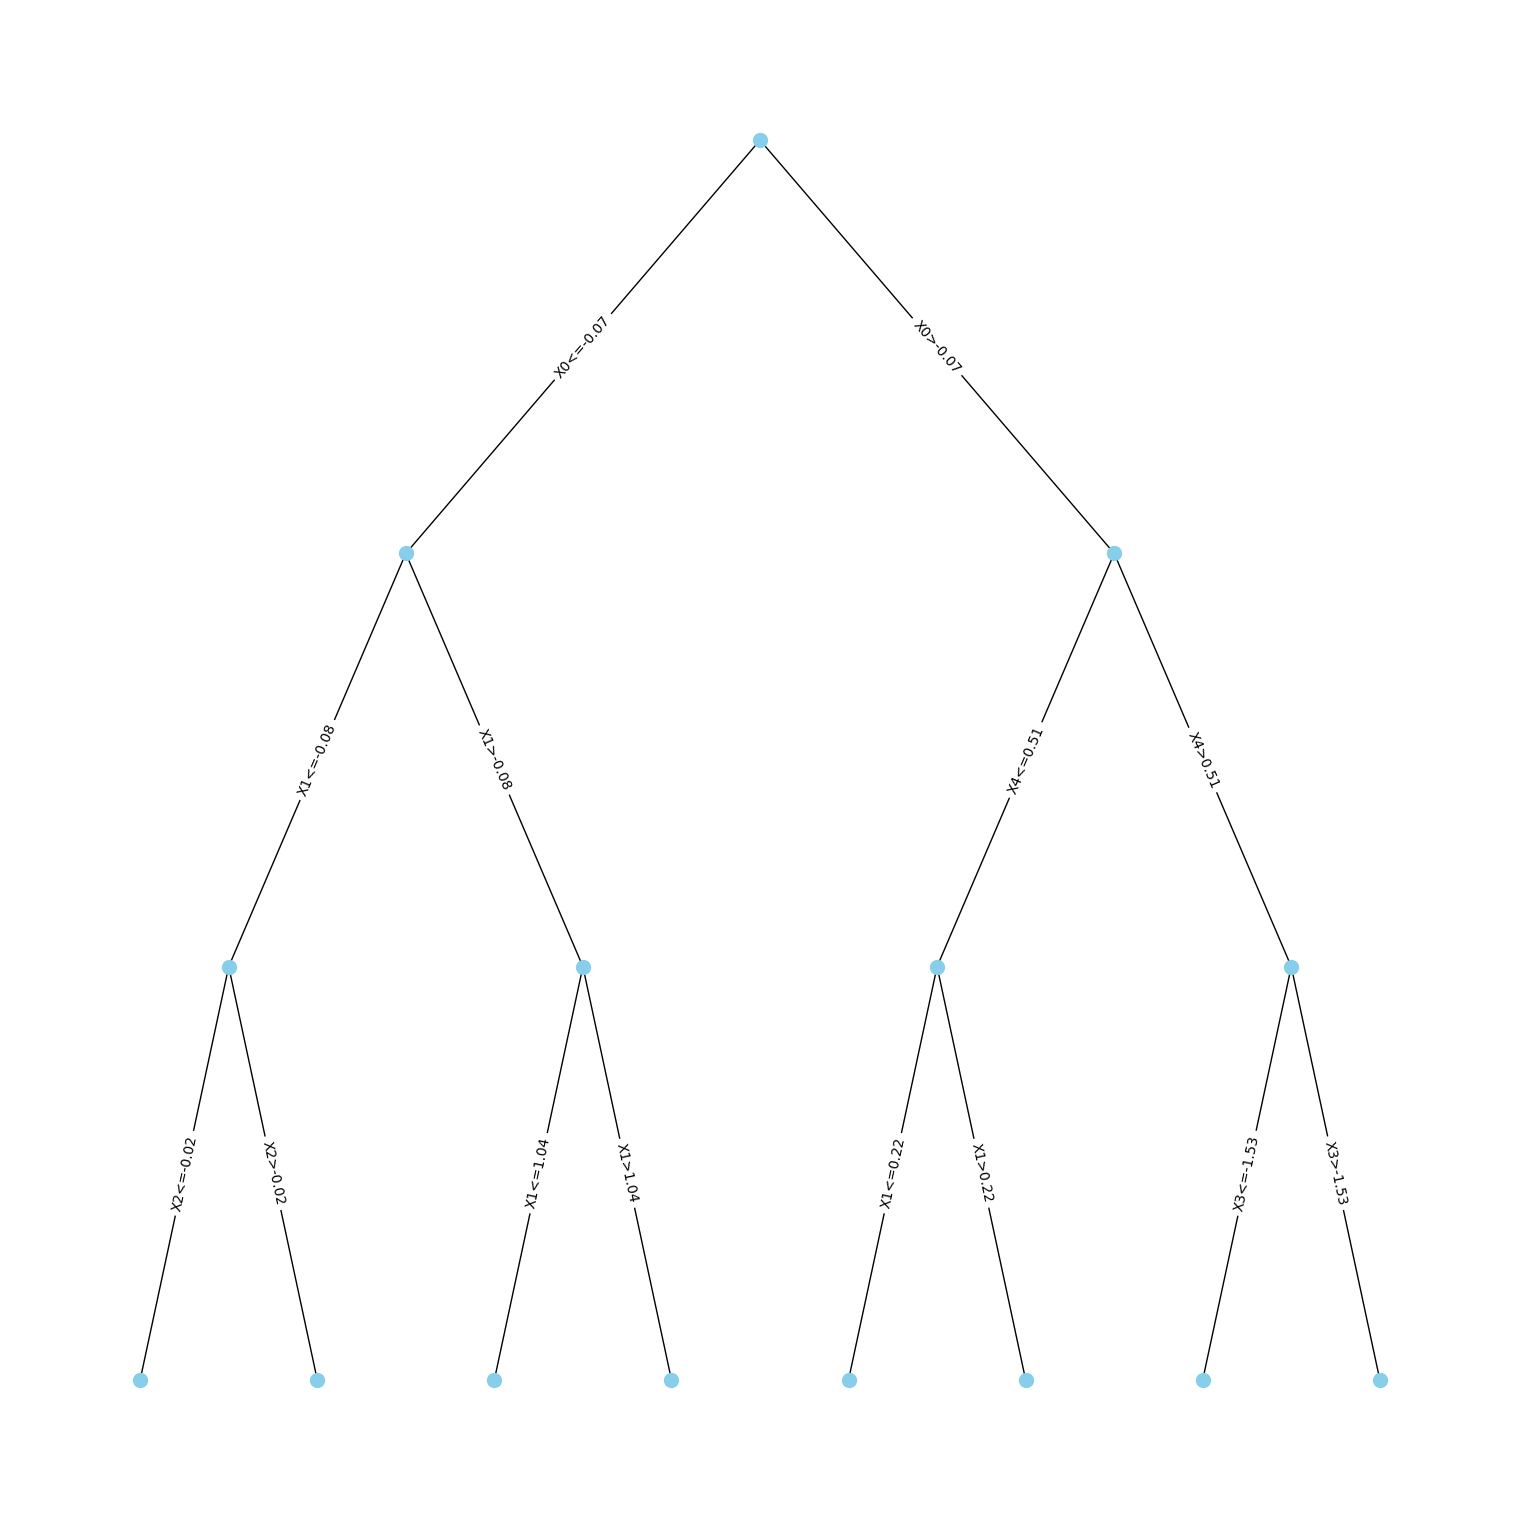

In [7]:
draw_tree(reg_tree.root)

In [8]:
reg_tree.bottom_up_pruning(level=0.1)

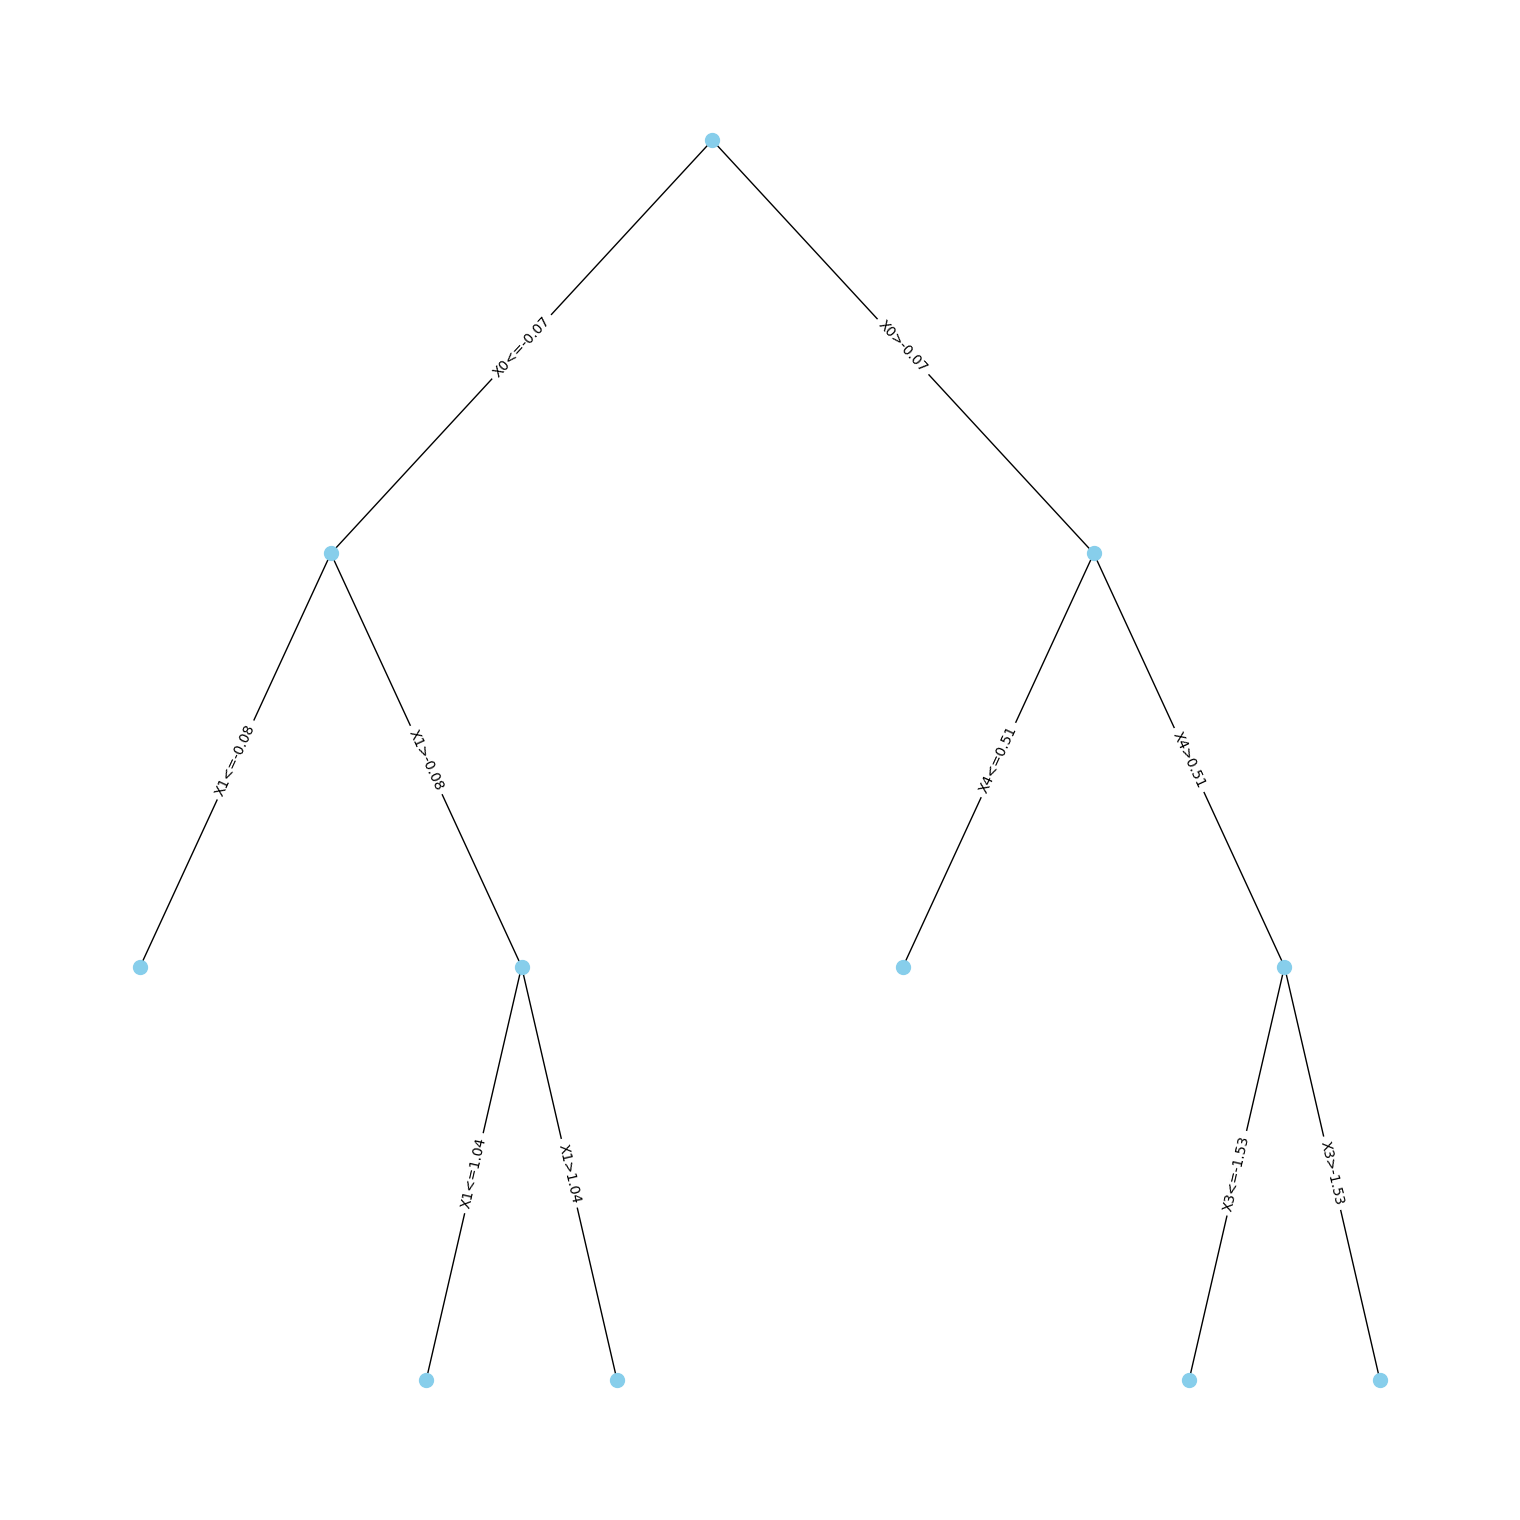

In [9]:
draw_tree(reg_tree.root)

In [10]:
pruned_pred_test = reg_tree.predict(X_test)

In [11]:
RMSE_pruned = np.mean((y_test - pruned_pred_test)**2)
naive_RMSE = np.mean((np.ones((n_test,))*np.mean(y) - y_test)**2)

In [12]:
print(RMSE_unpruned, RMSE_pruned, naive_RMSE)

1.641054806699476 1.194446638119015 2.013488155175738


In [24]:
def pred_sim(start, end, n_test, n=50, p = 5, 
             a = 1, b = 1, 
             
             prune_level=0.1):
    unpruned_RMSE_test = []
    pruned_RMSE_test = []
    mean_RMSE_test = []
    unpruned_RMSE_train = []
    pruned_RMSE_train = []
    mean_RMSE_train = []
    for i in range(start, end):
        print(i, "th simulation")
        # Generate training set
        X = np.random.normal(size=(n, p))
        mu = b * ((X[:, 0] <= 0) * (1 + a * (X[:, 1] > 0) + (X[:, 2] * X[:, 1] <= 0)))
        sd = 1.5
        noise_sd = 0.5
        y = mu + np.random.normal(size=(n,), scale=sd)
        # Create and train the regression tree
        reg_tree = RegressionTree(min_samples_split=10, max_depth=3, min_proportion=0.2)
        reg_tree.fit(X, y, sd=noise_sd)
        
        # Generate testing set
        X_test = np.random.normal(size=(n_test, p))
        mu_test = b * ((X_test[:, 0] <= 0) * (1 + a * (X_test[:, 1] > 0)
                                              + (X_test[:, 2] * X_test[:, 1] <= 0)))
        y_test = mu_test + np.random.normal(size=(n_test,), scale=sd)
        pred_test = reg_tree.predict(X_test)
        pred_train = reg_tree.predict(X)
        # Evaluate unpruned test error
        RMSE_unpruned_train = np.sqrt(np.mean((y - pred_train) ** 2))
        RMSE_unpruned_test = np.sqrt(np.mean((y_test - pred_test) ** 2))
        reg_tree.bottom_up_pruning(level=prune_level)
        
        # Evaluate pruned test error
        pruned_pred_train = reg_tree.predict(X)
        pruned_pred_test = reg_tree.predict(X_test)
        RMSE_pruned_train = np.sqrt(np.mean((y - pruned_pred_train) ** 2))
        RMSE_pruned_test = np.sqrt(np.mean((y_test - pruned_pred_test) ** 2))
        naive_RMSE_train = np.std(y)
        naive_RMSE_test = np.sqrt(np.mean((np.ones((n_test,)) * np.mean(y) - y_test) ** 2))
        
        unpruned_RMSE_train.append(RMSE_unpruned_train)
        pruned_RMSE_train.append(RMSE_pruned_train)
        mean_RMSE_train.append(naive_RMSE_train)
        unpruned_RMSE_test.append(RMSE_unpruned_test)
        pruned_RMSE_test.append(RMSE_pruned_test)
        mean_RMSE_test.append(naive_RMSE_test)
        
    return (unpruned_RMSE_train, pruned_RMSE_train, mean_RMSE_train,
            unpruned_RMSE_test, pruned_RMSE_test, mean_RMSE_test)
        

In [25]:
(unpruned_RMSE_train, pruned_RMSE_train, mean_RMSE_train,
 unpruned_RMSE_test, pruned_RMSE_test, mean_RMSE_test) = pred_sim(start=0, end=30)

0 th simulation
1 th simulation
2 th simulation
3 th simulation
4 th simulation
5 th simulation
6 th simulation
7 th simulation
8 th simulation
9 th simulation
10 th simulation
11 th simulation
12 th simulation
13 th simulation
14 th simulation
15 th simulation
16 th simulation
17 th simulation
18 th simulation
19 th simulation
20 th simulation
21 th simulation
22 th simulation
23 th simulation
24 th simulation
25 th simulation
26 th simulation
27 th simulation
28 th simulation
29 th simulation


In [26]:
def plot_training_testing_boxplots(train_errors_1, test_errors_1, 
                                   train_errors_2, test_errors_2, 
                                   train_errors_3, test_errors_3):
    """
    Plots boxplots of training and testing errors for 3 methods in two panels.

    Parameters:
    - train_errors_1, test_errors_1: Errors for method 1 (arrays or lists)
    - train_errors_2, test_errors_2: Errors for method 2 (arrays or lists)
    - train_errors_3, test_errors_3: Errors for method 3 (arrays or lists)
    """

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Combine data for the boxplots
    train_errors = [train_errors_1, train_errors_2, train_errors_3]
    test_errors = [test_errors_1, test_errors_2, test_errors_3]

    # Plot training errors in the first panel
    ax1.boxplot(train_errors, tick_labels=['Unpruned', 'Pruned', 'Naive'])
    ax1.set_title('Training Errors')
    ax1.set_xlabel('Method')
    ax1.set_ylabel('Error')

    # Plot testing errors in the second panel
    ax2.boxplot(test_errors, tick_labels=['Unpruned', 'Pruned', 'Naive'])
    ax2.set_title('Testing Errors')
    ax2.set_xlabel('Method')
    ax2.set_ylabel('Error')

    # Display the plots
    plt.tight_layout()
    plt.show()

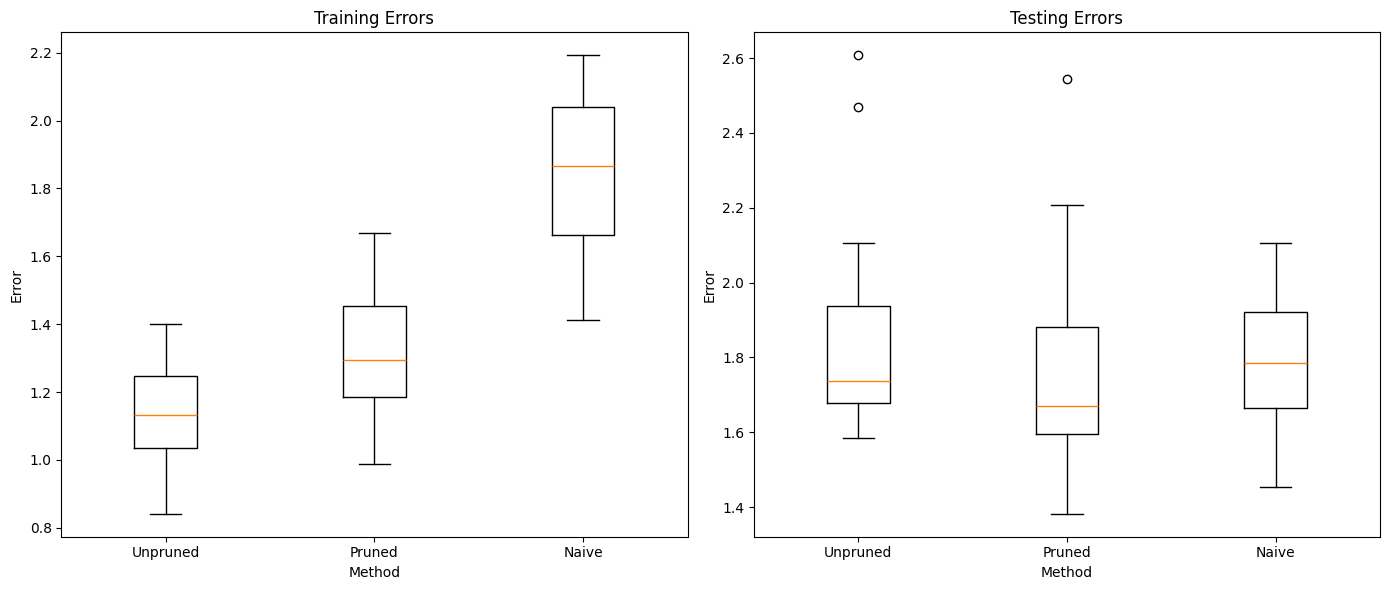

In [27]:
plot_training_testing_boxplots(unpruned_RMSE_train, unpruned_RMSE_test, 
                             pruned_RMSE_train, pruned_RMSE_test, 
                             mean_RMSE_train, mean_RMSE_test)

In [28]:
import seaborn as sns
import pandas as pd
def plot_training_testing_pointplots(train_errors_1, test_errors_1, 
                                     train_errors_2, test_errors_2, 
                                     train_errors_3, test_errors_3):
    """
    Plots pointplots of training and testing errors for 3 methods in two panels.

    Parameters:
    - train_errors_1, test_errors_1: Errors for method 1 (arrays or lists)
    - train_errors_2, test_errors_2: Errors for method 2 (arrays or lists)
    - train_errors_3, test_errors_3: Errors for method 3 (arrays or lists)
    """
    
    # Prepare data for the pointplots
    methods = ['Unpruned'] * len(train_errors_1) + ['Pruned'] * len(train_errors_2) + ['Naive'] * len(train_errors_3)
    errors_train = train_errors_1 + train_errors_2 + train_errors_3
    errors_test = test_errors_1 + test_errors_2 + test_errors_3
    data_train = pd.DataFrame({'Method': methods, 'Error': errors_train, 'Type': 'Training'})
    data_test = pd.DataFrame({'Method': methods, 'Error': errors_test, 'Type': 'Testing'})
    data = pd.concat([data_train, data_test])

    # Create a figure with two pointplots
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot training errors in the first panel
    sns.pointplot(x='Method', y='Error', data=data_train, ax=ax[0])
    ax[0].set_title('Training Errors')
    ax[0].set_xlabel('Method')
    ax[0].set_ylabel('Error')

    # Plot testing errors in the second panel
    sns.pointplot(x='Method', y='Error', data=data_test, ax=ax[1])
    ax[1].set_title('Testing Errors')
    ax[1].set_xlabel('Method')
    ax[1].set_ylabel('Error')

    # Display the plots
    plt.tight_layout()
    plt.show()

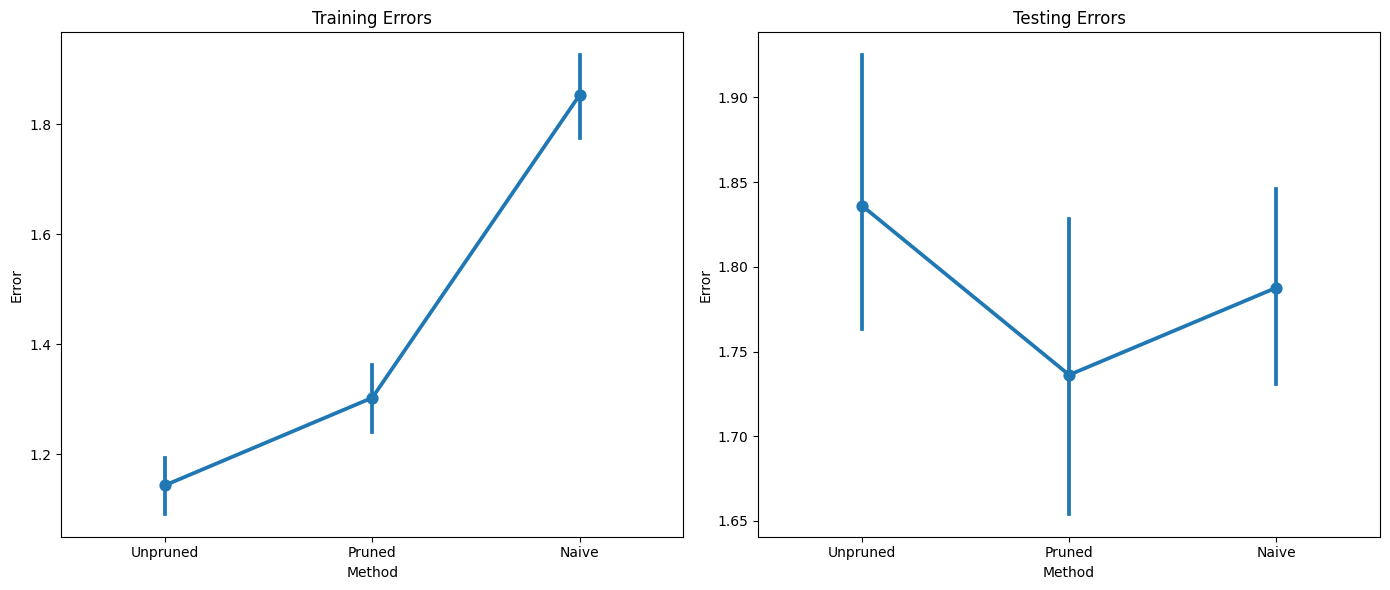

In [29]:
plot_training_testing_pointplots(unpruned_RMSE_train, unpruned_RMSE_test, 
                             pruned_RMSE_train, pruned_RMSE_test, 
                             mean_RMSE_train, mean_RMSE_test)